## Web Mapping and Geovisualisation. Assignment 2

## Introduction

Coffee consumption has been a frequent practice around the world, its presence has established a role that goes way beyond being an energetic beverage, it has become one of the main practices that are product of globalization, achieving a status that makes it a constant in people's everyday activities.

The increase in the consumption of coffee around the world has led to the point of massive expansion on the market, chains dedicated almost exclusively to coffee bean origin products have become some of the main commercial brands worldwide like Nero, Starbucks, Costa, among others. This consumption has notably rised in western countries (Akiyama, 2001)

Based on data obtained by the United States Department of Agriculture, which contains data from 1960 to 2023, we will be able to visualize statistics related to the coffee industry per country, based on public reports.

## Libraries

In [1]:
# Standard library imports
import datetime as dt

# Imports

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
import panel as pn
import plotly.express as px
import ipywidgets as widgets
import folium
from IPython.display import display
import requests
import osmnx as ox
import contextily as ctx
import seaborn as sns
import folium
import plotly.graph_objects as go


# Initialize Panel with extensions
pn.extension('plotly', design='material')

## Dataset

The dataset was obtained from the United States Department of Agriculture (USDA) (https://apps.fas.usda.gov/psdonline/app/index.html#/app/downloads) and later joined with coordinates obtained from https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json.

In [3]:
coffee = pd.read_csv("C:/Users/Max/Desktop/ENVS456/Ass2/koffee.csv")
print(coffee.columns.tolist())

['fid', 'Country', 'Year', 'Arabica Production', 'Bean Exports', 'Bean Imports', 'Beginning Stocks', 'Domestic Consumption', 'Ending Stocks', 'Exports', 'Imports', 'Other Production', 'Production', 'Roast & Ground Exports', 'Roast & Ground Imports', 'Robusta Production', 'Rst,Ground Dom. Consum', 'Soluble Dom. Cons.', 'Soluble Exports', 'Soluble Imports', 'Total Distribution', 'Total Supply', 'Lat', 'Lon']


In [4]:
unique_values = coffee['Country'].unique()
print(unique_values)

['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia' 'Benin'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Burundi' 'Cameroon' 'Canada'
 'Central African Republic' 'Chile' 'China' 'Colombia' 'Congo [Republic]'
 'Congo [DRC]' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Ethiopia' 'European Union' 'Gabon' 'Georgia' 'Ghana' 'Guatemala'
 'Guinea' 'Guyana' 'Haiti' 'Honduras' 'India' 'Indonesia' 'Iran' 'Jamaica'
 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'South Korea' 'Kosovo' 'Laos'
 'Liberia' 'Madagascar' 'Malawi' 'Malaysia' 'Mexico' 'Montenegro'
 'Morocco' 'New Caledonia' 'New Zealand' 'Nicaragua' 'Nigeria'
 'North Macedonia' 'Norway' 'Panama' 'Papua New Guinea' 'Paraguay' 'Peru'
 'Philippines' 'Russia' 'Rwanda' 'Saudi Arabia' 'Senegal' 'Serbia'
 'Sierra Leone' 'Singapore' 'South Africa' 'Sri Lanka' 'Switzerland'
 'Taiwan' 'Tanzania' 'Thailand' 'Togo' 'Trinidad and Tobago' 'Turkey'
 'Uganda' 'Ukraine' 'Uni

## The European Union

The USDA provides the coffee production records for the European Union (EU) as a single territory, this generates two problems unfortunately. First, we won't be able to visualize the EU boundaries through a map, as it is composed by many territories. The second is that we are deprived from every country member of the EU's single records. Because of this, we made modifications to the table, aassigning the same value for every country in the EU, while this does not solve our main issue, it does provide a support for visualising the territories correctly.

In [5]:
# List of European Union member countries
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
                'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 
                'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
                'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

# Find the countries 'European Union'
eu_data = coffee[coffee['Country'] == 'European Union']

# Remove EU entry from main DataFrame
coffee = coffee[coffee['Country'] != 'European Union']

# Eu data dristribution among EU countries
for country in eu_countries:
    new_data = eu_data.copy()
    new_data['Country'] = country
    # Divide values by the number of countries if necessary
    for col in new_data.columns:
        if new_data[col].dtype in [float, int]:  # Assume only numeric columns need division
            new_data[col] = new_data[col] / len(eu_countries)
    coffee = pd.concat([coffee, new_data], ignore_index=True)

# Now 'coffee' has the EU data distributed across its member countries

## Introduction to the dataset from a territorial perspective

We will generate a basemap with a single value as an introduction to our theme. Coffee exports

In [37]:
def update_map_date(selected_date):
    # DataFrame based on the year variable
    filtered_coffee = coffee[coffee['Year'] == 2023].copy()
    
    # Scatter geo plot with custom hover information
    fig = px.scatter_geo(filtered_coffee, lat='Lat', lon='Lon', hover_name= 'Total Distribution', custom_data=['Country', 'Imports'])
    
  # Hover template to display 'Total Distribution' and 'Country'
    fig.update_traces(hovertemplate='<b>Country:</b> %{customdata[0]}<br><b>Imports:</b> %{customdata[1]}')
    
    return fig

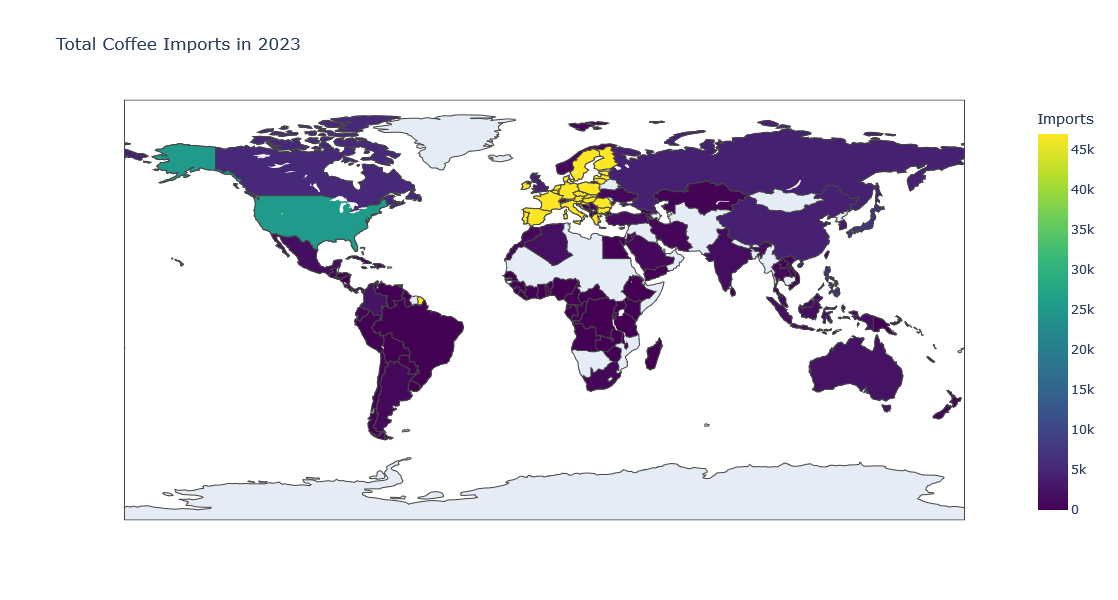

In [38]:
def update_map_date(selected_date):
    # Filter the DataFrame based on the selected date
    filtered_coffee = coffee[coffee['Year'] == 2023].copy()
    
    # Create the choropleth map
    fig = px.choropleth(filtered_coffee, 
                        locations='Country', 
                        locationmode='country names', 
                        color='Imports', 
                        hover_name='Country',
                        hover_data=['Imports'],
                        color_continuous_scale='Viridis',
                        labels={'Imports': 'Imports'},
                        title=f'Total Coffee Imports in {2023}',
                        height=600, width=1000)
    
    return fig

fig = update_map_date(2023)
fig.show()

## Interactive features

As the dataset covers many categories, we will implement some widgets to the visor that will allows us to have a deeper understanding on the distribution of each variable, for that, we are going to reload our dataset so it doesn't interfere with our previous output.

In [8]:
coffeemap = pd.read_csv("C:/Users/Max/Desktop/ENVS456/Ass2/koffee.csv")

name_mapping = {
    'Congo [Republic]': 'Republic of the Congo',
    'Congo [DRC]': 'Democratic Republic of the Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'North Macedonia': 'Macedonia',
    'United States': 'United States of America',
    'Tanzania': 'United Republic of Tanzania'}

# Replace the country names based on the mapping
coffeemap['Country'] = coffeemap['Country'].replace(name_mapping)

# List of European Union member countries
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
                'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 
                'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
                'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

# Find the countries 'European Union'
eu_data = coffeemap[coffeemap['Country'] == 'European Union']

# Remove EU entry from main DataFrame
coffeemap = coffeemap[coffeemap['Country'] != 'European Union']

# Eu data dristribution among EU countries
for country in eu_countries:
    new_data = eu_data.copy()
    new_data['Country'] = country
    # Divide values by the number of countries
    for col in new_data.columns:
        if new_data[col].dtype in [float, int]:  
            new_data[col] = new_data[col] / len(eu_countries)
    coffeemap = pd.concat([coffeemap, new_data], ignore_index=True)

## Basemap

We are going to implement the Folium library for the generation of our new basemap. This will be complemented with some widgets that encourage navigation through the different categories that compose the dataset.

In [31]:
# Load world geojson data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = requests.get(world_geojson_url).json()

# Create Panel widgets

unique_years_map = coffeemap['Year'].unique()

# Slider widget for selecting the year
year_slider_map = pn.widgets.IntSlider(name='Select Year', start=unique_years_map.min(), end=unique_years_map.max(), step=1,
                                       value=unique_years_map.min(), width=400)

# Dropdown widget for selecting a country
country_dropdown_map = pn.widgets.Select(name='Select Country', options=list(coffeemap['Country'].unique()))


# Dropdown widget for selecting a category
available_categories_map = [col for col in coffeemap.columns if col not in ['fid', 'Country', 'Year', 'Lat', 'Lon']]
category_dropdown_map = pn.widgets.Select(name='Select Category', options=available_categories_map, width=400)

def create_map():
    year_map = year_slider_map.value
    category_map = category_dropdown_map.value
    filtered_data_map = coffeemap[coffeemap['Year'] == year_map]

    # Create a Folium map object
    m = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB Positron")

    # Add choropleth layer
    folium.Choropleth(
        geo_data=world_geojson,
        data=filtered_data_map,
        columns=['Country', category_map],
        key_on='feature.properties.name',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=category_map
    ).add_to(m)

    # Important: Convert map to HTML string
    return m._repr_html_()

# Update function to refresh the map based on widget changes
def update_choropleth(event=None):
    html_content = create_map()  # Get updated HTML string from create_map
    map_pane.object = html_content  # Update the HTML pane's content

# Initially create the map and set up the HTML pane
initial_map_html = create_map()
map_pane = pn.pane.HTML(initial_map_html, width=1000, height=600)

# Watch for changes in the widgets
year_slider_map.param.watch(update_choropleth, 'value')
category_dropdown_map.param.watch(update_choropleth, 'value')

# Create Panel layout
panel = pn.Column('## Coffee Production Choropleth Map',pn.Row(year_slider_map, category_dropdown_map),map_pane)


## Radial plot panel

We will also include a panel for single analysis, based on the country the user wishes to study. It deploys every value of each category into a single plot which represents in a much more clear way, it is also equipped with the year slider which gives up to more than 60 years of records.

In [32]:
# Function to update country plots based on the selected year, country, and category
def update_country_plots(selected_year, selected_country):
    filtered_data_map = coffeemap[(coffeemap['Year'] == selected_year) & (coffeemap['Country'] == selected_country)].copy()
    
    # Exclude 'Lat' and 'Lon' columns from filtered data
    filtered_data_map = filtered_data_map.drop(columns=['Lat', 'Lon'])
    
    categories_map = list(filtered_data_map.columns)[4:]  # Exclude the first four columns which are 'fid', 'Country', 'Year', 'Lat', and 'Lon'
    values_map = filtered_data_map.iloc[0, 4:].tolist()

    spider_fig_map = go.Figure()
    spider_fig_map.add_trace(go.Scatterpolar(
        r=values_map,
        theta=categories_map,
        fill='toself',
        name=selected_country,
        line=dict(color='orange')
    ))
    spider_fig_map.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, max(values_map)])),
        title=f'Coffee Production in {selected_country} - {selected_year}'
    )
    
    return spider_fig_map

country_panel_map = pn.Column(pn.Row(year_slider_map, country_dropdown_map), 
                          pn.bind(update_country_plots, year_slider_map, country_dropdown_map))

## Temporal Growth Panel

Finally, we will add a line graph that shows the evolution of each country in every category present in our dataset.

In [33]:
# Function to update the growth plot based on the selected country and category
def update_growth_plot(selected_country, selected_category):
    filtered_data_map = coffeemap[coffeemap['Country'] == selected_country].copy()
    filtered_data_map = filtered_data_map.drop(columns=['Lat', 'Lon'])
    
    growth_fig = px.line(filtered_data_map, x='Year', y=selected_category, title=f'Statistical Growth of {selected_category} in {selected_country}')
    growth_fig.update_layout(yaxis_title='Quantity', xaxis_title='Year', xaxis=dict(range=[coffeemap['Year'].min(), coffeemap['Year'].max()]))
    
    return growth_fig

growth_panel = pn.Column(country_dropdown_map, category_dropdown_map, pn.bind(update_growth_plot, country_dropdown_map, category_dropdown_map))

Having all the panels generated, we join them into a single output.

In [34]:
tabs = pn.Tabs(
    ('Global Year', panel),
    ('Country Details', country_panel_map),
    ('Temporal Growth', growth_panel))

tabs.servable()

Tabs(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi...)
        [0] Markdown(str, design=<class 'panel.theme.materi...)
        [1] Row(design=<class 'panel.theme.materi...)
            [0] IntSlider(design=<class 'panel.theme.materi..., end=2023, name='Select Year', start=1960, value=1960, width=400)
            [1] Select(design=<class 'panel.theme.materi..., options=['Arabica Production', ...], value='Arabica Production', width=400)
        [2] HTML(str, design=<class 'panel.theme.materi..., height=600, sizing_mode='fixed', width=1000)
    [1] Column(design=<class 'panel.theme.materi...)
        [0] Row(design=<class 'panel.theme.materi...)
            [0] IntSlider(design=<class 'panel.theme.materi..., end=2023, name='Select Year', start=1960, value=1960, width=400)
            [1] Select(design=<class 'panel.theme.materi..., options=['Albania', 'Algeria', ...], value='Albania')
        [1] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi...)
    [2] Column(design=<class 'panel.theme.materi...)
        [0] Select(design=<class 'panel.theme.materi..., options=['Albania', 'Algeria', ...], value='Albania')
        [1] Select(design=<class 'panel.theme.materi..., options=['Arabica Production', ...], value='Arabica Production', width=400)
        [2] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi...)

In [28]:
The dashboard can be accessed through here

KeyError: '25617f97-d240-4c88-bb8e-5e262c935d81'

The main purpose of this dashboard is to allow the user to analyze both in a general and specific way the evolution of the coffee industry around the world. The countries that show in grey are those that are not present in the dataset. The dashboard presents to us the distribution of the different variables regarding coffee production around the world from 1960 to 2023 through the use of the year slider. The second panel gives us access to an individual display of each country stats for single analysis, also equipped with the temporal modifier. Finally, the third panel allows the full temporal visualization of each category for a single country.

Based on the results we can confirm what we mentioned in the beginning, coffee consumptions is marking a tendency of increase worldwide, with a special focus on the western countries. Traditional bean producers like South America, South and East Asia have their economy considerable boosted thanks to the production of the bean, the most notable case is Brazil, with 10% of its total GDP being purely coffe production and distribution (Caldarelli, Gilio, Zilberman, 2019).

It's almost certain that the expansion of the bean will continue crossing thresholds, as it is a product that can be innovated, which makes it highly linkable with marketing, the main economic activity of the world, it does present a challenge for deeper analysis towards how different factors can influence in their own way each territory that participates in the coffee market.

## References

Akiyama, T., 2001. Coffee Market Liberalization since 1990. Commodity market reforms: lessons of two decades. pp. 83-120.
Caldarelli, C., Gilio, L., Zilberman, D., 2019. The Coffee Market in Brazil: challenges and policy guidelines.
